## Test if the calibration is doing what I expect

This calculates residual offsets from that calibrated images by applying a tailcut + some dilation around the signal, and using non-signal pixels as background.

In [1]:
from ctapipe.io.hessio import hessio_event_source
from ctapipe.utils import datasets
from ctapipe.calib import CameraCalibrator
from ctapipe.image import tailcuts_clean, dilate
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook, tqdm
from scipy.stats import poisson
import os
%matplotlib inline

In [2]:
cal = CameraCalibrator(None,None)

In [54]:
hists = {}

def process_pedestal(event, output=False):
    global hists

    for tel in event.dl0.tels_with_data:
        geom = CameraGeometry.guess(*event.inst.pixel_pos[tel], event.inst.optical_foclen[tel])
        im = event.dl1.tel[tel].image[0]

        # select pixels that are not signal and calculate means and std of them (they should be pedestals):
        mask = tailcuts_clean(geom, im, picture_thresh=14, boundary_thresh=7)
        for ii in range(3):
            mask = dilate(geom, mask)

        if output:
            print("evt:{:10d} tel: {:03d}/{:10.10s} mean: {:5.3f} std: {:5.3f}"\
                  .format(event.dl0.event_id, tel, geom.cam_id, 
                          im[~mask].mean(), im[~mask].std()))
        
        hist, ed = np.histogram(im[~mask], bins=200, range=[-10,10])

        if geom.cam_id in hists:
            hists[geom.cam_id][0] += hist
            hists[geom.cam_id][2] += len(im[~mask]) # counter
        else:
            hists[geom.cam_id] = [hist,ed,len(im[~mask])]


Loop over events in a file and collect residual statistics on all images

In [55]:
os.environ['CTAPIPE_SVC_PATH']='/Users/kosack/Data/CTA/Prod3'  # so I can also use my larger test files
hists = {} 

infile = datasets.get_dataset('gamma_test_large.simtel.gz')  # from ctapipe_resources
#infile = datasets.get_dataset('gamma_20deg_180deg_run1000___cta-prod3-demo_desert-2150m-Paranal-demo2rad_cone10.simtel.gz')  # from my dir

for event in tqdm_notebook(hessio_event_source(infile, max_events=100), total=100):
    cal.calibrate(event)
    process_pedestal(event)

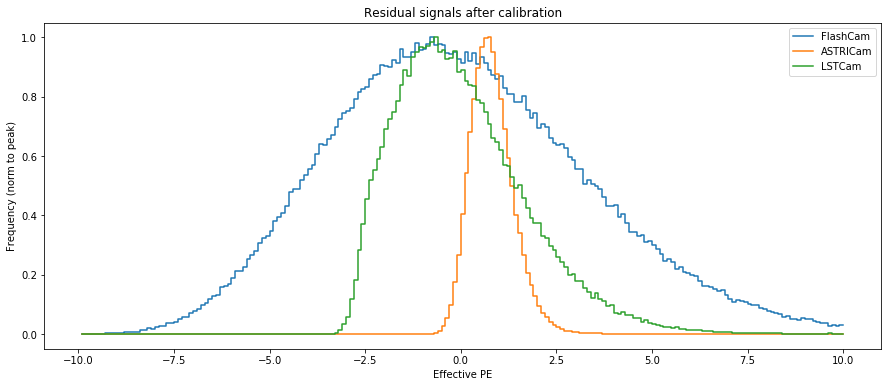

In [56]:
plt.figure(figsize=(15,6))

#poiss = poiss/poiss.max()
for cam in hists:
    X = hists[cam][1][1:]
    H = hists[cam][0]
    plt.plot(X, H/H.max(), label=cam, ls='steps')


plt.xlabel("Effective PE")
plt.ylabel("Frequency (norm to peak)")
plt.legend()
plt.title("Residual signals after calibration")